In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('dataset/in_and_out.csv', encoding='cp949')
data.head()

,사용월,호선명,지하철역,04시-05시 승차인원,04시-05시 하차인원,05시-06시 승차인원,05시-06시 하차인원,06시-07시 승차인원,06시-07시 하차인원,07시-08시 승차인원,...,23시-24시 하차인원,00시-01시 승차인원,00시-01시 하차인원,01시-02시 승차인원,01시-02시 하차인원,02시-03시 승차인원,02시-03시 하차인원,03시-04시 승차인원,03시-04시 하차인원,작업일자
0,202504,1호선,동대문,650,26,11355,2005,10238,7181,18411,...,9939,938,3210,3,321,0,0,0,0,20250503
1,202504,1호선,동묘앞,117,3,2844,819,4206,5444,9689,...,4897,120,1996,3,267,0,0,0,0,20250503
2,202504,1호선,서울역,712,48,10654,9668,29272,64058,97455,...,29252,5212,8018,10,262,0,0,0,0,20250503
3,202504,1호선,시청,124,5,2267,5900,3888,28761,7841,...,3763,606,1015,0,15,0,0,0,0,20250503
4,202504,1호선,신설동,381,18,9393,2330,10420,9020,24157,...,9416,455,3039,0,0,1,2,0,0,20250503


C:\Users\kkh02\AppData\Local\Temp\ipykernel_3788\850459830.py:20: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh02\AppData\Local\Temp\ipykernel_3788\850459830.py:20: UserWarning: Glyph 49849 (\N{HANGUL SYLLABLE SEUNG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh02\AppData\Local\Temp\ipykernel_3788\850459830.py:20: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh02\AppData\Local\Temp\ipykernel_3788\850459830.py:20: UserWarning: Glyph 51064 (\N{HANGUL SYLLABLE IN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\kkh02\AppData\Local\Temp\ipykernel_3788\850459830.py:20: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\kkh02\llll\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from f

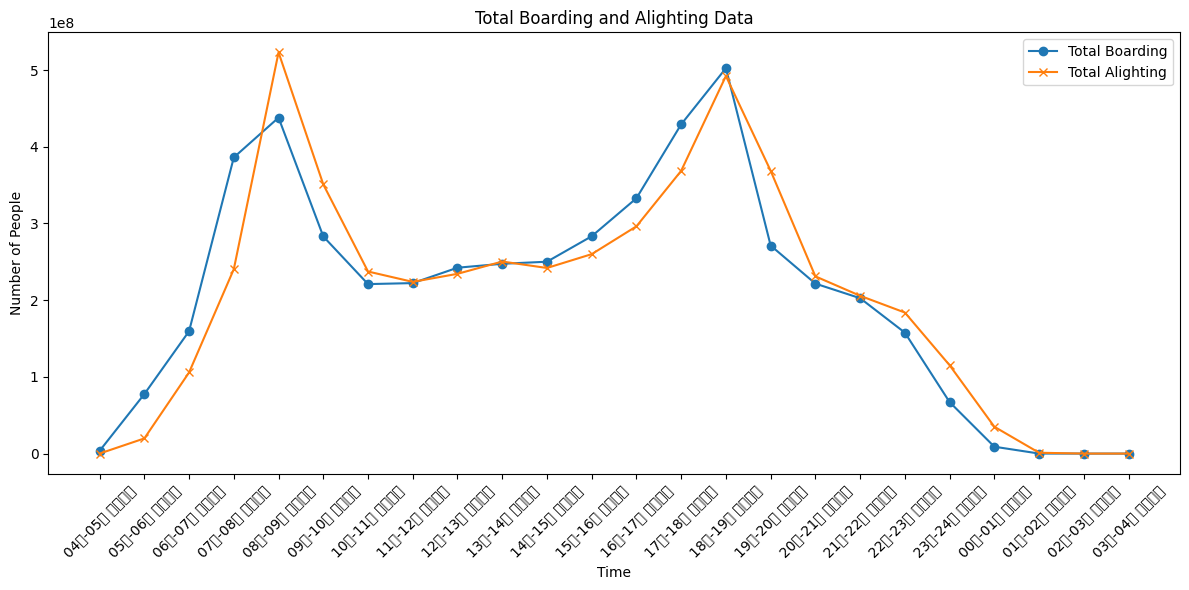

In [4]:
boarding_cols = [col for col in data.columns if '승차인원' in col]
alighting_cols = [col for col in data.columns if '하차인원' in col]

boarding_data = data[boarding_cols].sum(axis=1)
alighting_data = data[alighting_cols].sum(axis=1)

grouped = data.groupby('사용월')

grouped_boarding = grouped[boarding_cols].sum()
grouped_alighting = grouped[alighting_cols].sum()

plt.figure(figsize=(12, 6))
plt.plot(boarding_cols, data[boarding_cols].sum(), label='Total Boarding', marker='o')
plt.plot(boarding_cols, data[alighting_cols].sum(), label='Total Alighting', marker='x')  # x축을 boarding_cols로 통일
plt.title('Total Boarding and Alighting Data')
plt.xlabel('Time')
plt.ylabel('Number of People')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# 시간대 컬럼 정렬
time_cols = [col for col in data.columns if '승차' in col or '하차' in col]
# 시간대 추출 및 정렬
def time_sort_key(x):
    h, m = map(int, x.split('-')[0].split('시'))
    return h * 60 + m if m else h * 60
time_order = sorted(set(col.split()[0] for col in time_cols), key=lambda x: int(x[:2])*60+int(x[3:5]))
ordered_cols = []
for t in time_order:
    ordered_cols.append(f'{t} 승차인원')
    ordered_cols.append(f'{t} 하차인원')

# 데이터 정렬
data = data[['사용월', '호선명', '지하철역'] + ordered_cols]

# 월 기준 훈련/테스트 분할
train = data[data['사용월'] < 202501]
test = data[data['사용월'] >= 202501]

# 시계열 입력/타겟 생성 함수
def make_xy(df, window_size=3):
    X, y = [], []
    for _, group in df.groupby(['호선명', '지하철역']):
        vals = group[ordered_cols].values
        # 한 역에 여러 달 데이터가 있을 수 있으니 각 행별로 생성
        for row in vals:
            # 시간대별로 슬라이딩 윈도우
            for i in range(0, len(ordered_cols)//2 - window_size):
                start = i*2
                end = (i+window_size)*2
                X.append(row[start:end])
                y.append(row[end:end+2])
    return np.array(X), np.array(y)

# 입력/타겟 생성
window_size = 3
X_train, y_train = make_xy(train, window_size)
X_test, y_test = make_xy(test, window_size)

# 정규화
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)
y_train = scaler_y.fit_transform(y_train)
y_test = scaler_y.transform(y_test)

# LSTM 입력 형태로 변환
X_train = X_train.reshape(-1, window_size, 2)
X_test = X_test.reshape(-1, window_size, 2)

# y는 (샘플수, 2) 형태(승차/하차)


Epoch 1/100


c:\Users\kkh02\llll\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6499/6499 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 0.0010 - val_loss: 1.3061e-04
Epoch 2/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 5.9464e-04 - val_loss: 1.4679e-04
Epoch 3/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 17s 3ms/step - loss: 4.6886e-04 - val_loss: 1.3659e-04
Epoch 4/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 4.2855e-04 - val_loss: 1.0494e-04
Epoch 5/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - loss: 4.0194e-04 - val_loss: 1.1160e-04
Epoch 6/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - loss: 3.7993e-04 - val_loss: 1.0565e-04
Epoch 7/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 59s 9ms/step - loss: 3.6788e-04 - val_loss: 1.0016e-04
Epoch 8/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 48s 4ms/step - loss: 3.5246e-04 - val_loss: 1.1807e-04
Epoch 9/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 3.4173e-04 - val_loss: 1.0869e-04
Epoch 10/100
6499/6499 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - loss: 3.2830e-04 - val_loss: 9.9923e-05
Epoch 11/100
6499/6499 ━━━━━━━━━━━━

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,896 (226.16 KB)

 Trainable params: 19,298 (75.38 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,598 (150.78 KB)

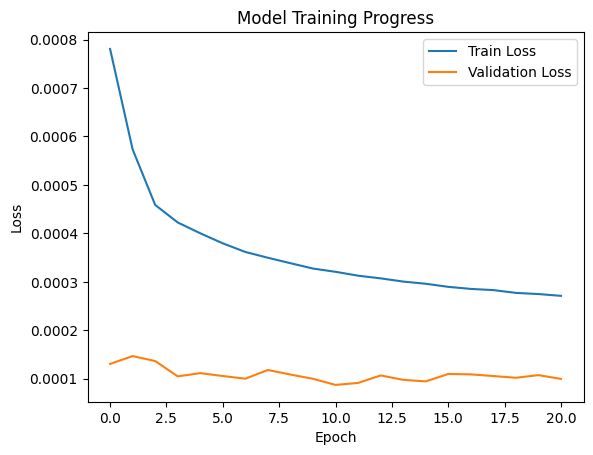

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# LSTM 모델 설계
model = Sequential([
    LSTM(64, input_shape=(3, 2), return_sequences=False),  # 3시간 단위, 승차/하차 2개 특성
    Dense(32, activation='relu'),
    Dense(2)  # 승차/하차 인원 예측 (2개 출력)
])

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

model.compile(optimizer='adam', loss='mse')

history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

model.summary()


plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Training Progress')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



In [ ]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import numpy as np


# 기존 LSTM 입력: (샘플, 3, 2) → (샘플, 6)
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


models = {
    'LinearRegression': LinearRegression(),
    'Ridge': MultiOutputRegressor(Ridge()),
    'Lasso': MultiOutputRegressor(Lasso()),
    'RandomForest': RandomForestRegressor(n_estimators=30, max_depth=10, n_jobs=-1, random_state=42),
    'SVR': MultiOutputRegressor(SVR())
}

r2_scores = {}

for name, model in models.items():
    model.fit(X_train_flat, y_train)
    y_pred = model.predict(X_test_flat)
    
r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
r2_scores[name] = r2
print(f"{name} R²: {r2:.4f}")


plt.figure(figsize=(8,5))
plt.bar(r2_scores.keys(), r2_scores.values(), color='skyblue')
plt.ylabel('R² Score')
plt.title('scikit-learn 회귀모델별 테스트셋 R² 비교')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()
